In [17]:
import joblib, json

rf_resource_model = joblib.load("rf_resource_model.pkl")
rf_inter_model = joblib.load("rf_interactivity_model.pkl")
rf_priority_model = joblib.load("rf_priority_model.pkl")
rf_execution_model = joblib.load("rf_execution_model.pkl")

le_resource = joblib.load("le_resource.pkl")
le_inter = joblib.load("le_inter.pkl")
le_priority = joblib.load("le_priority.pkl")
le_execution = joblib.load("le_execution.pkl")

resource_feats = json.load(open("resource_features.json"))
interactivity_feats = json.load(open("interactivity_features.json"))
priority_feats = json.load(open("priority_features.json"))
execution_feats = json.load(open("execution_features.json"))


In [18]:
# 📌 Task class to represent and process individual tasks
import json
from datetime import datetime

class Task:
    def __init__(self, task_dict):
        # Basic identity info
        self.timestamp = datetime.fromisoformat(task_dict.get('Timestamp')) if task_dict.get('Timestamp') else None
        self.pid = int(task_dict.get('PID', 0))
        self.name = task_dict.get('Name', f'Task-{self.pid}')
        self.ppid = int(task_dict.get('PPid', 0))
        self.cmdline = task_dict.get('Cmdline', '')

        # Core system-level info
        self.state = task_dict.get('State', 'S')
        self.threads = int(task_dict.get('Threads', 1))
        self.vmrss = self._parse_vmrss(task_dict.get('VmRSS', '0 kB'))
        self.priority = int(task_dict.get('Priority', 20))
        self.nice = int(task_dict.get('Nice', 0))
        self.cpu_usage = float(task_dict.get('CPU_Usage_%', 0))
        self.total_time_ticks = float(task_dict.get('Total_Time_Ticks', 0))
        self.elapsed_time = float(task_dict.get('Elapsed_Time_sec', 0))
        self.voluntary_ctxt_switches = int(task_dict.get('Voluntary_ctxt_switches', 0))
        self.nonvoluntary_ctxt_switches = int(task_dict.get('Nonvoluntary_ctxt_switches', 0))
        self.scheduling_policy = task_dict.get('Scheduling_Policy', 'SCHED_OTHER')
        self.sched_stats = task_dict.get('Sched_Stats', '')
        self.io_stats = task_dict.get('IO_Stats', '')

        # Classification fields (to be filled later)
        self.resource_type = None
        self.interactivity = None
        self.execution_time_class = None
        self.priority_class = None
        self.score = None
        self.assigned_scheduler = None

    def _parse_vmrss(self, value):
        try:
            return float(value.strip().replace('kB', '').strip())
        except:
            return 0.0

    @property
    def interactivity_score(self):
        return self.voluntary_ctxt_switches / (self.nonvoluntary_ctxt_switches + 1)

    @property
    def is_sleeping(self):
        return int('sleeping' in str(self.state).lower())

    def to_feature_dict(self):
        return {
            'CPU_Usage_%': self.cpu_usage,
            'Nice': self.nice,
            'Total_Time_Ticks': self.total_time_ticks,
            'Elapsed_Time_sec': self.elapsed_time,
            'Voluntary_ctxt_switches': self.voluntary_ctxt_switches,
            'Nonvoluntary_ctxt_switches': self.nonvoluntary_ctxt_switches,
            'VmRSS': self.vmrss,
            'Priority': self.priority,
            'Threads': self.threads,
            'interactivity_score': self.interactivity_score,
            'is_sleeping': self.is_sleeping,
            'State': self.state,
            'Scheduling_Policy': self.scheduling_policy
        }

    def dict(self):
        return {
            "Timestamp": self.timestamp.isoformat() if self.timestamp else None,
            "PID": self.pid,
            "Name": self.name,
            "State": self.state,
            "PPid": self.ppid,
            "Threads": self.threads,
            "VmRSS": f"{self.vmrss} kB",
            "Priority": self.priority,
            "Nice": self.nice,
            "CPU_Usage_%": self.cpu_usage,
            "Total_Time_Ticks": self.total_time_ticks,
            "Elapsed_Time_sec": self.elapsed_time,
            "Voluntary_ctxt_switches": self.voluntary_ctxt_switches,
            "Nonvoluntary_ctxt_switches": self.nonvoluntary_ctxt_switches,
            "Scheduling_Policy": self.scheduling_policy,
            "Sched_Stats": self.sched_stats,
            "IO_Stats": self.io_stats,
            "Cmdline": self.cmdline
        }

    def __repr__(self):
        return (f"<{self.name} (PID: {self.pid}) | CPU: {self.cpu_usage:.2f}% | "
                f"Res: {self.resource_type} | Interact: {self.interactivity} | "
                f"Exec: {self.execution_time_class} | Prio: {self.priority_class} | "
                f"Score: {self.score} | Scheduler: {self.assigned_scheduler}>")


In [19]:
# 🧪 Step 1B: Define sample input tasks
raw_tasks_json = [
    # 🧠 Task 1: High CPU, more involuntary → CPU-bound | Real-time | High | Long
    """
    {
        "Timestamp": "2025-07-29T10:00:00.000000",
        "PID": "10",
        "Name": "video_encoder",
        "State": "R (running)",
        "PPid": "1",
        "Threads": "4",
        "VmRSS": "512000 kB",
        "Priority": 10,
        "Nice": -5,
        "CPU_Usage_%": 95.0,
        "Total_Time_Ticks": 5000,
        "Elapsed_Time_sec": 100.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "1000",
        "Scheduling_Policy": "SCHED_FIFO",
        "Sched_Stats": "encoding task",
        "IO_Stats": "",
        "Cmdline": "ffmpeg process"
    }
    """,
    # 🎮 Task 2: Low CPU, more voluntary → IO-bound | Interactive | Medium | Short
    """
    {
        "Timestamp": "2025-07-29T10:01:00.000000",
        "PID": "11",
        "Name": "file_manager",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "2",
        "VmRSS": "20480 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 5.0,
        "Total_Time_Ticks": 120,
        "Elapsed_Time_sec": 1000.0,
        "Voluntary_ctxt_switches": "500",
        "Nonvoluntary_ctxt_switches": "20",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "IO waiting",
        "IO_Stats": "",
        "Cmdline": "nautilus"
    }
    """,
    # ⚙️ Task 3: Mid CPU, equal ctxt → Mixed | Other | Medium | Medium
    """
    {
        "Timestamp": "2025-07-29T10:02:00.000000",
        "PID": "12",
        "Name": "system_logger",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "1",
        "VmRSS": "15000 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 35.0,
        "Total_Time_Ticks": 1200,
        "Elapsed_Time_sec": 80.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "100",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "logging",
        "IO_Stats": "",
        "Cmdline": "rsyslogd"
    }
    """,
    # 💤 Task 4: Low priority → IO-bound | Background | Low | Short
    """
    {
        "Timestamp": "2025-07-29T10:03:00.000000",
        "PID": "13",
        "Name": "backup_daemon",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "1",
        "VmRSS": "250000 kB",
        "Priority": 25,
        "Nice": 15,
        "CPU_Usage_%": 2.0,
        "Total_Time_Ticks": 200,
        "Elapsed_Time_sec": 5000.0,
        "Voluntary_ctxt_switches": "200",
        "Nonvoluntary_ctxt_switches": "5",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "periodic backups",
        "IO_Stats": "",
        "Cmdline": "backup -s"
    }
    """,
    # 🔥 Task 5: Batch processing → Mixed | Batch | Medium | Long
    """
    {
        "Timestamp": "2025-07-29T10:04:00.000000",
        "PID": "14",
        "Name": "data_cruncher",
        "State": "R (running)",
        "PPid": "1",
        "Threads": "8",
        "VmRSS": "1024000 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 75.0,
        "Total_Time_Ticks": 4000,
        "Elapsed_Time_sec": 60.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "100",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "batch stats...",
        "IO_Stats": "",
        "Cmdline": "python crunch.py"
    }
    """
]

# ✅ Step 1C: Convert to Task objects
tasks = [Task(json.loads(task_str)) for task_str in raw_tasks_json]

# ✅ Visual Check
for task in tasks:
    print(task)


<video_encoder (PID: 10) | CPU: 95.00% | Res: None | Interact: None | Exec: None | Prio: None | Score: None | Scheduler: None>
<file_manager (PID: 11) | CPU: 5.00% | Res: None | Interact: None | Exec: None | Prio: None | Score: None | Scheduler: None>
<system_logger (PID: 12) | CPU: 35.00% | Res: None | Interact: None | Exec: None | Prio: None | Score: None | Scheduler: None>
<backup_daemon (PID: 13) | CPU: 2.00% | Res: None | Interact: None | Exec: None | Prio: None | Score: None | Scheduler: None>
<data_cruncher (PID: 14) | CPU: 75.00% | Res: None | Interact: None | Exec: None | Prio: None | Score: None | Scheduler: None>


In [20]:
import numpy as np

def classify_task(task_obj):
    # Extract feature dictionary
    features = task_obj.to_feature_dict()

    # Derived / engineered features
    features['interactivity_score'] = task_obj.interactivity_score
    features['is_sleeping'] = task_obj.is_sleeping
    features['avg_cpu_time'] = features['Total_Time_Ticks'] / (features['Elapsed_Time_sec'] + 1e-5)
    features['cpu_to_elapsed_ratio'] = features['CPU_Usage_%'] / (features['Elapsed_Time_sec'] + 1e-5)

    label_encoders = {
    'State': joblib.load("le_state.pkl"),
    'Scheduling_Policy': joblib.load("le_scheduling_policy.pkl")
    }

    # Encode categorical features using preloaded label encoders
    for cat_feat in ['State', 'Scheduling_Policy']:
        val = str(features.get(cat_feat, 'unknown'))
        le = label_encoders.get(cat_feat)
        if le:
            if val in le.classes_:
                features[cat_feat] = le.transform([val])[0]
            else:
                # If unseen label, map to a default known value (first class)
                features[cat_feat] = le.transform([le.classes_[0]])[0]
        else:
            features[cat_feat] = 0

    # Load feature sets
    resource_feats = json.load(open("resource_features.json"))
    interactivity_feats = json.load(open("interactivity_features.json"))
    priority_feats = json.load(open("priority_features.json"))
    execution_feats = json.load(open("execution_features.json"))

    # Build model inputs
    import pandas as pd

    def make_input(feats):
        row = {feat: features.get(feat, 0) for feat in feats}
        return pd.DataFrame([row])


    input_resource     = make_input(resource_feats)
    input_interactivity = make_input(interactivity_feats)
    input_priority     = make_input(priority_feats)
    input_execution    = make_input(execution_feats)

    # Predict with models
    pred_resource = rf_resource_model.predict(input_resource)[0]
    pred_inter = rf_inter_model.predict(input_interactivity)[0]
    pred_execution = rf_execution_model.predict(input_execution)[0]
    pred_priority = rf_priority_model.predict(input_priority)[0]

    # Return all labels
    return {
        "Resource_Type": pred_resource,
        "Interactivity": pred_inter,
        "Priority_Class": pred_priority,
        "Execution_Time_Class": pred_execution
    }


In [21]:
for task in tasks:
    predictions = classify_task(task)
    task.resource_type = predictions["Resource_Type"]
    task.interactivity = predictions["Interactivity"]
    task.execution_time_class = predictions["Execution_Time_Class"]
    task.priority_class = predictions["Priority_Class"]

print("\n🎯 Classified Tasks:")
for task in tasks:
    print(task)



🎯 Classified Tasks:
<video_encoder (PID: 10) | CPU: 95.00% | Res: Mixed | Interact: Other | Exec: Long | Prio: Medium | Score: None | Scheduler: None>
<file_manager (PID: 11) | CPU: 5.00% | Res: IO-bound | Interact: Interactive | Exec: Short | Prio: Medium | Score: None | Scheduler: None>
<system_logger (PID: 12) | CPU: 35.00% | Res: Mixed | Interact: Other | Exec: Short | Prio: Medium | Score: None | Scheduler: None>
<backup_daemon (PID: 13) | CPU: 2.00% | Res: IO-bound | Interact: Background | Exec: Short | Prio: Low | Score: None | Scheduler: None>
<data_cruncher (PID: 14) | CPU: 75.00% | Res: Mixed | Interact: Other | Exec: Long | Prio: Medium | Score: None | Scheduler: None>


In [22]:
def compute_task_score(task):
    # Define label-to-score mappings
    resource_scores = {'CPU-bound': 3, 'Mixed': 2, 'IO-bound': 1}
    interactivity_scores = {'Real-time': 3, 'Interactive': 2, 'Other': 1, 'Background': 1}
    exec_scores = {'Short': 3, 'Medium': 2, 'Long': 1}
    priority_scores = {'High': 3, 'Medium': 2, 'Low': 1}

    # Define weights
    weights = {
        'resource': 0.1,
        'interactivity': 0.4,
        'execution': 0.2,
        'priority': 0.3
    }

    score = (
        weights['resource'] * resource_scores.get(task.resource_type, 1) +
        weights['interactivity'] * interactivity_scores.get(task.interactivity, 1) +
        weights['execution'] * exec_scores.get(task.execution_time_class, 1) +
        weights['priority'] * priority_scores.get(task.priority_class, 1)
    )

    task.score = round(score, 3)  # Store on the task object
    return task.score


In [23]:
# def assign_scheduler(task):
#     # Emergency override (name-based)
#     if task.name.lower() in ['emergency', 'critical_alert', 'stopwatch']:
#         task.assigned_scheduler = "FIFO"
#         task.queue_name = "fifo_0"
#         return

#     score = task.score or compute_task_score(task)  # Ensure score is computed
#     if task.scheduling_policy == "SCHED_IDLE":
#        task.assigned_scheduler = "IDLE"
#        task.queue_name = "idle_queue"

#     # Interactivity & label-based mapping
#     if task.interactivity == 'Real-time' and task.priority_class == 'High':
#         task.assigned_scheduler = 'FIFO'
#         task.queue_name = 'fifo_1' if score >= 2.5 else 'fifo_2'

#     elif task.interactivity == 'Interactive' and task.execution_time_class == 'Short':
#         task.assigned_scheduler = 'RR'
#         task.queue_name = 'rr_1'

#     elif task.interactivity == 'Interactive':
#         task.assigned_scheduler = 'RR'
#         task.queue_name = 'rr_2'

#     elif score >= 2.5:
#         task.assigned_scheduler = 'FIFO'
#         task.queue_name = 'fifo_1'

#     else:
#         task.assigned_scheduler = 'CFS'
#         # CFS buckets based on score range
#         if score >= 2:
#             task.queue_name = 'cfs_1'
#         else:
#             task.queue_name = 'cfs_2'

#     return task.assigned_scheduler, task.queue_name


In [24]:
def assign_scheduler(task):
    if (task.scheduling_policy == "SCHED_FIFO" and task.priority == 0 ):
       task.assigned_scheduler = "FIFO"
       task.queue_name = "fifo_0"
       return

     # 💤 Explicit IDLE policy
    if task.scheduling_policy == "SCHED_IDLE":
       task.assigned_scheduler = "IDLE"
       task.queue_name = "idle_queue"
       return

    score = task.score or compute_task_score(task)

    rt, inter, exec_t, prio = task.resource_type, task.interactivity, task.execution_time_class, task.priority_class

    if rt == "CPU-bound" and inter == "Real-time" and prio == "High":
       task.assigned_scheduler = "FIFO"
       task.queue_name = "fifo_1" if score >= 2.5 else "fifo_2"

    elif inter == "Real-time" or (inter == "Interactive" and exec_t == "Short"):
       task.assigned_scheduler = "RR"
       task.queue_name = "rr_1" if score >= 2.5 else "rr_2"

    elif inter == "Interactive":
       task.assigned_scheduler = "RR"
       task.queue_name = "rr_2"

    elif inter == "Background" and exec_t == "Long" and prio == "Low":
       task.assigned_scheduler = "CFS"
       task.queue_name = "cfs_3"

    elif score >= 2.8:
       task.assigned_scheduler = "FIFO"
       task.queue_name = "fifo_1"

    elif score < 1.5:
       task.assigned_scheduler = "CFS"
       task.queue_name = "cfs_3"

    else:
       task.assigned_scheduler = "CFS"
       if score >= 2:
           task.queue_name = "cfs_1"
       elif score >= 1:
           task.queue_name = "cfs_2"
       else:
           task.queue_name = "cfs_3"

    return task.assigned_scheduler, task.queue_name

In [25]:
for task in tasks:
    compute_task_score(task)
    assign_scheduler(task)

for task in tasks:
    print(task)


<video_encoder (PID: 10) | CPU: 95.00% | Res: Mixed | Interact: Other | Exec: Long | Prio: Medium | Score: 1.4 | Scheduler: CFS>
<file_manager (PID: 11) | CPU: 5.00% | Res: IO-bound | Interact: Interactive | Exec: Short | Prio: Medium | Score: 2.1 | Scheduler: RR>
<system_logger (PID: 12) | CPU: 35.00% | Res: Mixed | Interact: Other | Exec: Short | Prio: Medium | Score: 1.8 | Scheduler: CFS>
<backup_daemon (PID: 13) | CPU: 2.00% | Res: IO-bound | Interact: Background | Exec: Short | Prio: Low | Score: 1.4 | Scheduler: CFS>
<data_cruncher (PID: 14) | CPU: 75.00% | Res: Mixed | Interact: Other | Exec: Long | Prio: Medium | Score: 1.4 | Scheduler: CFS>


In [26]:
from collections import deque
import random

class CoreQueue:
    def __init__(self, core_id):
        self.core_id = core_id
        self.fifo0 = deque()  # 🔥 Stop-class
        self.fifo1 = deque()
        self.fifo2 = deque()
        self.rr1 = deque()
        self.rr2 = deque()
        self.cfs1 = []
        self.cfs2 = []
        self.cfs3 = []        # 💤 Lowest priority
        self.idle = deque()
        self.running_task = None
        self.time = 0
        self.log = []

    def calculate_cfs_timeslice(self, cfs_queue):
        SCHED_LATENCY = 6.0
        MIN_GRANULARITY = 1.0

        if not cfs_queue:
           return

        total_weight = sum(getattr(task, "weight", 1024) for task in cfs_queue)
        for task in cfs_queue:
            weight = getattr(task, "weight", 1024)
            proportion = weight / total_weight
            task.time_slice = max(MIN_GRANULARITY, proportion * SCHED_LATENCY)

    def enqueue(self, task):
        if not hasattr(task, 'remaining_time'):
            task.remaining_time = int(task.total_time_ticks // 100)
            task.vruntime = 0
            task.time_slice = 0  # Will be set dynamically if CFS

        scheduler = task.assigned_scheduler
        queue = task.sub_queue

        if scheduler == 'FIFO':
            if queue == 'fifo_0':
                self.fifo0.append(task)
            elif queue == 'fifo_1':
                self.fifo1.append(task)
            else:
                self.fifo2.append(task)
        elif scheduler == 'RR':
            if queue == 'rr_1':
                self.rr1.append(task)
            else:
                self.rr2.append(task)
        elif scheduler == 'CFS':
            if queue == 'cfs_1':
                self.cfs1.append(task)
                self.cfs1.sort(key=lambda t: t.vruntime)
            elif queue == 'cfs_2':
                self.cfs2.append(task)
                self.cfs2.sort(key=lambda t: t.vruntime)
            else:
                self.cfs3.append(task)
                self.cfs3.sort(key=lambda t: t.vruntime)
        elif scheduler == 'IDLE':
            self.idle.append(task)


    def preempt_if_needed(self):
        if self.running_task is None:
            return False  # Nothing to preempt

        current_policy = self.running_task.assigned_scheduler
        current_sub = self.running_task.sub_queue

        if self.fifo0 and current_queue != 'fifo_0':
            return True
        if self.fifo1 and current_queue not in ['fifo_0', 'fifo_1']:
            return True
        if self.rr1 and current_queue not in ['fifo_0', 'fifo_1', 'rr_1']:
            return True
        return False

    def step(self):
        task, scheduler_used = None, None
        if self.preempt_if_needed():
            self.enqueue(self.running_task)  # requeue current
            self.running_task = None

        # Only use IDLE if all other queues are empty
        if self.fifo0:
            task = self.fifo0.popleft()
            scheduler_used = 'FIFO_0'
        elif self.fifo1:
            task = self.fifo1.popleft()
            scheduler_used = 'FIFO_1'
        elif self.fifo2:
            task = self.fifo2.popleft()
            scheduler_used = 'FIFO_2'
        elif self.rr1:
            task = self.rr1.popleft()
            scheduler_used = 'RR_1'
        elif self.rr2:
            task = self.rr2.popleft()
            scheduler_used = 'RR_2'
        elif self.cfs1:
            self.calculate_cfs_timeslice(self.cfs1)
            task = self.cfs1.pop(0)
            scheduler_used = 'CFS_1'
        elif self.cfs2:
            self.calculate_cfs_timeslice(self.cfs2)
            task = self.cfs2.pop(0)
            scheduler_used = 'CFS_2'
        elif self.cfs3:
            self.calculate_cfs_timeslice(self.cfs3)
            task = self.cfs3.pop(0)
            scheduler_used = 'CFS_3'
        elif not (self.fifo0 or self.fifo1 or self.fifo2 or self.rr1 or self.rr2 or self.cfs1 or self.cfs2 or self.cfs3) and self.idle:
            task = self.idle.popleft()
            scheduler_used = 'IDLE'
        else:
            return None

        slice_time = 2 if 'RR' in scheduler_used else 1
        run_time = min(slice_time, task.remaining_time)

        task.remaining_time -= run_time
        task.vruntime += run_time

        if task.remaining_time > 0:
            self.enqueue(task)

        log = {
            "PID": task.pid,
            "Task": task.name,
            "Scheduler": scheduler_used,
            "Core": self.core_id,
            "Score": task.score,
            "Start": self.time,
            "End": self.time + run_time
        }
        self.time += run_time

        if log["Start"] != log["End"]:
            self.log.append(log)

        return log


class SchedulerSystem:
    def __init__(self, num_cores=4):
        self.cores = [CoreQueue(core_id=i) for i in range(num_cores)]
        self.logs = []

    def assign_task(self, task):
        def core_load_score(core):
            return (
                3 * len(core.fifo0) +
                2 * (len(core.fifo1) + len(core.fifo2)) +
                1.5 * (len(core.rr1) + len(core.rr2)) +
                2 * (len(core.cfs1) + len(core.cfs2) + len(core.cfs3)) +
                1 * len(core.idle)
            )

        selected_core = min(self.cores, key=core_load_score)
        selected_core.enqueue(task)

    def run(self, max_ticks=100):
        for tick in range(max_ticks):
            for core in self.cores:
                log = core.step()
                if log:
                    self.logs.append(log)

    def print_logs(self):
        for log in self.logs:
            print(f"[Core {log['Core']}] {log['Task']} (PID {log['PID']}) | "
                  f"{log['Scheduler']} | Score: {log['Score']} | "
                  f"Start: {log['Start']} End: {log['End']}")



In [27]:
# 💡 Assume you already classified + scored + scheduled tasks
scheduler_system = SchedulerSystem(num_cores=4)

# 🔁 Assign tasks to cores
for task in tasks:
    task.score = compute_task_score(task)       # 1️⃣ Score it
    task.assigned_scheduler, task.sub_queue = assign_scheduler(task)  # 2️⃣ Assign scheduler & sub-queue
    scheduler_system.assign_task(task)

# ▶️ Run simulated execution
scheduler_system.run(max_ticks=100)  # Run 20 time units

# 📋 Print logs
scheduler_system.print_logs()


[Core 0] video_encoder (PID 10) | CFS_3 | Score: 1.4 | Start: 0 End: 1
[Core 1] file_manager (PID 11) | RR_2 | Score: 2.1 | Start: 0 End: 1
[Core 2] system_logger (PID 12) | CFS_2 | Score: 1.8 | Start: 0 End: 1
[Core 3] backup_daemon (PID 13) | CFS_3 | Score: 1.4 | Start: 0 End: 1
[Core 0] video_encoder (PID 10) | CFS_3 | Score: 1.4 | Start: 1 End: 2
[Core 1] data_cruncher (PID 14) | CFS_3 | Score: 1.4 | Start: 1 End: 2
[Core 2] system_logger (PID 12) | CFS_2 | Score: 1.8 | Start: 1 End: 2
[Core 3] backup_daemon (PID 13) | CFS_3 | Score: 1.4 | Start: 1 End: 2
[Core 0] video_encoder (PID 10) | CFS_3 | Score: 1.4 | Start: 2 End: 3
[Core 1] data_cruncher (PID 14) | CFS_3 | Score: 1.4 | Start: 2 End: 3
[Core 2] system_logger (PID 12) | CFS_2 | Score: 1.8 | Start: 2 End: 3
[Core 0] video_encoder (PID 10) | CFS_3 | Score: 1.4 | Start: 3 End: 4
[Core 1] data_cruncher (PID 14) | CFS_3 | Score: 1.4 | Start: 3 End: 4
[Core 2] system_logger (PID 12) | CFS_2 | Score: 1.8 | Start: 3 End: 4
[Core 0]

In [28]:
import json
from collections import deque
import heapq

# Constants for Linux CFS simulation
SCHED_LATENCY = 6.0  # total time period for CFS fairness window
MIN_GRANULARITY = 1.0

# Nice value to weight mapping (Linux style)
nice_to_weight = {
    -20: 88761, -15: 54484, -10: 33554, -5: 18705, 0: 1024,
     5: 335, 10: 110, 15: 36, 19: 15
}

class Task:
    def __init__(self, raw_data):
        self.raw = raw_data
        self.timestamp = raw_data.get("Timestamp")
        self.pid = int(raw_data.get("PID"))
        self.name = raw_data.get("Name")
        self.state = raw_data.get("State")
        self.ppid = int(raw_data.get("PPid"))
        self.threads = int(raw_data.get("Threads"))
        self.vmrss_kb = int(raw_data.get("VmRSS", "0").split()[0])
        self.priority = int(raw_data.get("Priority"))
        self.nice = int(raw_data.get("Nice"))
        self.cpu_percent = float(raw_data.get("CPU_Usage_%"))
        self.total_time_ticks = int(raw_data.get("Total_Time_Ticks"))
        self.elapsed_time_sec = float(raw_data.get("Elapsed_Time_sec"))
        self.vol_ctxt_switches = int(raw_data.get("Voluntary_ctxt_switches"))
        self.invol_ctxt_switches = int(raw_data.get("Nonvoluntary_ctxt_switches"))
        self.sched_policy = raw_data.get("Scheduling_Policy")
        self.sched_stats = raw_data.get("Sched_Stats")
        self.io_stats = raw_data.get("IO_Stats")
        self.cmdline = raw_data.get("Cmdline")

        self.vruntime = 0.0
        self.remaining_time = self.total_time_ticks // 100
        self.time_slice = 0
        self.weight = nice_to_weight.get(self.nice, 1024)

    def __repr__(self):
        return f"<{self.name} (PID: {self.pid}) | {self.sched_policy} | Remain: {self.remaining_time}>"

class Core:
    def __init__(self, core_id):
        self.core_id = core_id
        self.fifo_queue = deque()
        self.rr_queue = deque()
        self.cfs_queue = []
        self.idle_queue = deque()
        self.running_task = None
        self.running_policy = None
        self.time = 0
        self.logs = []

    def enqueue(self, task):
        if task.sched_policy == 'SCHED_FIFO':
            self.fifo_queue.append(task)
        elif task.sched_policy == 'SCHED_RR':
            self.rr_queue.append(task)
        elif task.sched_policy == 'SCHED_OTHER':
            heapq.heappush(self.cfs_queue, (task.vruntime, task))
        elif task.sched_policy == 'SCHED_IDLE':
            self.idle_queue.append(task)

    def preempt_if_needed(self):
        if self.running_task is None:
            return False
        if self.fifo_queue and self.running_policy != 'SCHED_FIFO':
            return True
        if self.rr_queue and self.running_policy not in ['SCHED_FIFO', 'SCHED_RR']:
            return True
        return False

    def calculate_cfs_timeslice(self):
        total_weight = sum(task.weight for _, task in self.cfs_queue)
        if not total_weight:
            return
        for i in range(len(self.cfs_queue)):
            _, task = self.cfs_queue[i]
            proportion = task.weight / total_weight
            task.time_slice = max(MIN_GRANULARITY, proportion * SCHED_LATENCY)

    def pick_next_task(self):
        if self.fifo_queue:
            return self.fifo_queue[0], 'SCHED_FIFO', self.fifo_queue[0].remaining_time
        elif self.rr_queue:
            task = self.rr_queue.popleft()
            return task, 'SCHED_RR', min(task.time_slice or 2, task.remaining_time)
        elif self.cfs_queue:
            self.calculate_cfs_timeslice()
            _, task = heapq.heappop(self.cfs_queue)
            return task, 'SCHED_OTHER', min(task.time_slice, task.remaining_time)
        elif self.idle_queue:
            task = self.idle_queue.popleft()
            return task, 'SCHED_IDLE', min(1, task.remaining_time)
        else:
            return None, None, None

    def step(self):
        if self.preempt_if_needed():
            self.enqueue(self.running_task)
            self.running_task = None
            self.running_policy = None

        if not self.running_task:
            self.running_task, self.running_policy, run_time = self.pick_next_task()
            if not self.running_task:
                return None
        else:
            run_time = 1

        task = self.running_task
        policy = self.running_policy
        task.remaining_time -= run_time

        if policy == 'SCHED_OTHER':
            task.vruntime += run_time * (1024 / task.weight)

        if policy == 'SCHED_RR' and task.remaining_time > 0:
            self.rr_queue.append(task)
            self.running_task = None
            self.running_policy = None
        elif policy == 'SCHED_OTHER' and task.remaining_time > 0:
            heapq.heappush(self.cfs_queue, (task.vruntime, task))
            self.running_task = None
            self.running_policy = None
        elif policy == 'SCHED_FIFO' and task.remaining_time <= 0:
            self.fifo_queue.popleft()
            self.running_task = None
            self.running_policy = None
        elif policy == 'SCHED_IDLE' and task.remaining_time > 0:
            self.idle_queue.append(task)
            self.running_task = None
            self.running_policy = None
        elif task.remaining_time <= 0:
            self.running_task = None
            self.running_policy = None

        log = {
            'PID': task.pid,
            'Task': task.name,
            'Scheduler': policy,
            'Core': self.core_id,
            'Start': self.time,
            'End': self.time + run_time
        }

        self.time += run_time
        self.logs.append(log)
        return log

class LinuxScheduler:
    def __init__(self, num_cores=4):
        self.cores = [Core(i) for i in range(num_cores)]
        self.global_logs = []

    def assign_task(self, task):
        least_loaded = min(
            self.cores,
            key=lambda c: len(c.fifo_queue) + len(c.rr_queue) + len(c.cfs_queue) + len(c.idle_queue)
        )
        least_loaded.enqueue(task)

    def run(self, max_ticks=100):
        for _ in range(max_ticks):
            for core in self.cores:
                log = core.step()
                if log:
                    self.global_logs.append(log)

    def print_logs(self):
        for log in self.global_logs:
            print(f"[Core {log['Core']}] {log['Task']} (PID {log['PID']}) | {log['Scheduler']} | Start: {log['Start']} End: {log['End']}")


In [29]:
raw_tasks_json = [
    """
    {
        "Timestamp": "2025-07-29T10:00:00.000000",
        "PID": "10",
        "Name": "video_encoder",
        "State": "R (running)",
        "PPid": "1",
        "Threads": "4",
        "VmRSS": "512000 kB",
        "Priority": 10,
        "Nice": -5,
        "CPU_Usage_%": 95.0,
        "Total_Time_Ticks": 5000,
        "Elapsed_Time_sec": 100.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "1000",
        "Scheduling_Policy": "SCHED_FIFO",
        "Sched_Stats": "encoding task",
        "IO_Stats": "",
        "Cmdline": "ffmpeg process"
    }
    """,
    """
    {
        "Timestamp": "2025-07-29T10:01:00.000000",
        "PID": "11",
        "Name": "file_manager",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "2",
        "VmRSS": "20480 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 5.0,
        "Total_Time_Ticks": 120,
        "Elapsed_Time_sec": 1000.0,
        "Voluntary_ctxt_switches": "500",
        "Nonvoluntary_ctxt_switches": "20",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "IO waiting",
        "IO_Stats": "",
        "Cmdline": "nautilus"
    }
    """,
    """
    {
        "Timestamp": "2025-07-29T10:02:00.000000",
        "PID": "12",
        "Name": "system_logger",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "1",
        "VmRSS": "15000 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 35.0,
        "Total_Time_Ticks": 1200,
        "Elapsed_Time_sec": 80.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "100",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "logging",
        "IO_Stats": "",
        "Cmdline": "rsyslogd"
    }
    """,
    """
    {
        "Timestamp": "2025-07-29T10:03:00.000000",
        "PID": "13",
        "Name": "backup_daemon",
        "State": "S (sleeping)",
        "PPid": "1",
        "Threads": "1",
        "VmRSS": "250000 kB",
        "Priority": 25,
        "Nice": 15,
        "CPU_Usage_%": 2.0,
        "Total_Time_Ticks": 200,
        "Elapsed_Time_sec": 5000.0,
        "Voluntary_ctxt_switches": "200",
        "Nonvoluntary_ctxt_switches": "5",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "periodic backups",
        "IO_Stats": "",
        "Cmdline": "backup -s"
    }
    """,
    """
    {
        "Timestamp": "2025-07-29T10:04:00.000000",
        "PID": "14",
        "Name": "data_cruncher",
        "State": "R (running)",
        "PPid": "1",
        "Threads": "8",
        "VmRSS": "1024000 kB",
        "Priority": 20,
        "Nice": 0,
        "CPU_Usage_%": 75.0,
        "Total_Time_Ticks": 4000,
        "Elapsed_Time_sec": 60.0,
        "Voluntary_ctxt_switches": "100",
        "Nonvoluntary_ctxt_switches": "100",
        "Scheduling_Policy": "SCHED_OTHER",
        "Sched_Stats": "batch stats...",
        "IO_Stats": "",
        "Cmdline": "python crunch.py"
    }
    """
]

import json

# Parse into task objects
task_list = [Task(json.loads(js)) for js in raw_tasks_json]

# Initialize and assign tasks
linux_sched = LinuxScheduler(num_cores=4)
for task in task_list:
    linux_sched.assign_task(task)

# Simulate scheduler
linux_sched.run(max_ticks=100)

# Print the logs
linux_sched.print_logs()


[Core 0] video_encoder (PID 10) | SCHED_FIFO | Start: 0 End: 50
[Core 1] file_manager (PID 11) | SCHED_OTHER | Start: 0 End: 1
[Core 2] system_logger (PID 12) | SCHED_OTHER | Start: 0 End: 6.0
[Core 3] backup_daemon (PID 13) | SCHED_OTHER | Start: 0 End: 2
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 50 End: 56.0
[Core 2] system_logger (PID 12) | SCHED_OTHER | Start: 6.0 End: 12.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 56.0 End: 62.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 62.0 End: 68.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 68.0 End: 74.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 74.0 End: 80.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 80.0 End: 86.0
[Core 0] data_cruncher (PID 14) | SCHED_OTHER | Start: 86.0 End: 90.0


In [30]:
import pandas as pd
from collections import defaultdict

def compute_metrics(logs, scheduler_name):
    task_stats = defaultdict(lambda: {
        "Start Times": [],
        "End Time": 0,
        "Execution Time": 0,
        "Scheduler": None,
        "Core": None
    })

    total_ticks_per_core = defaultdict(int)
    busy_ticks_per_core = defaultdict(int)
    context_switches = 0

    for log in logs:
        pid = log["PID"]
        task_stats[pid]["Start Times"].append(log["Start"])
        task_stats[pid]["End Time"] = log["End"]
        task_stats[pid]["Execution Time"] += log["End"] - log["Start"]
        task_stats[pid]["Scheduler"] = log["Scheduler"]
        task_stats[pid]["Core"] = log["Core"]

        busy_ticks_per_core[log["Core"]] += (log["End"] - log["Start"])
        total_ticks_per_core[log["Core"]] = max(total_ticks_per_core[log["Core"]], log["End"])
        context_switches += 1

    task_data = []
    for pid, data in task_stats.items():
        arrival_time = 0  # assumed
        completion_time = data["End Time"]
        tat = completion_time - arrival_time
        execution_time = data["Execution Time"]
        response_time = min(data["Start Times"]) - arrival_time
        waiting_time = tat - execution_time
        stretch = tat / execution_time if execution_time > 0 else 0

        task_data.append({
            "PID": pid,
            "Scheduler": data["Scheduler"],
            "Core": data["Core"],
            "Turnaround Time": tat,
            "Execution Time": execution_time,
            "Response Time": response_time,
            "Waiting Time": waiting_time,
            "Stretch": round(stretch, 2),
            "Completed": 1 if execution_time > 0 else 0
        })

    task_df = pd.DataFrame(task_data)

    # Compute CPU Utilization
    core_utils = {}
    for core in total_ticks_per_core:
        busy = busy_ticks_per_core.get(core, 0)
        total = total_ticks_per_core[core]
        core_utils[core] = (busy / total) * 100 if total > 0 else 0

    avg_core_util = sum(core_utils.values()) / len(core_utils) if core_utils else 0
    load_balance_score = max(core_utils.values()) - min(core_utils.values()) if core_utils else 0

    # Jain's Fairness Index
    cpu_times = task_df["Execution Time"].tolist()
    numerator = sum(cpu_times) ** 2
    denominator = len(cpu_times) * sum([x**2 for x in cpu_times])
    fairness = numerator / denominator if denominator != 0 else 0

    summary = {
        "Scheduler": scheduler_name,
        "Completion Ratio (%)": round(100 * task_df["Completed"].sum() / len(task_df), 2),
        "Avg Core Utilization (%)": round(avg_core_util, 2),
        "Load Balance Score": round(load_balance_score, 2),
        "Jain Fairness Index": round(fairness, 4),
        "Total Context Switches": context_switches
    }

    return task_df, summary, core_utils

def compare_schedulers(logs1, logs2, name1="Linux", name2="AI"):
    df1, summary1, util1 = compute_metrics(logs1, name1)
    df2, summary2, util2 = compute_metrics(logs2, name2)

    summary_df = pd.DataFrame([summary1, summary2])
    return df1, df2, summary_df , util1, util2


In [31]:
import matplotlib.pyplot as plt

def plot_scheduler_metrics(df_linux, df_ai, core_utils_linux, core_utils_ai):
    def bar_plot_metric(metric, title, ylabel):
        plt.figure(figsize=(10, 5))
        plt.bar(df_linux["PID"], df_linux[metric], alpha=0.7, label="Linux")
        plt.bar(df_ai["PID"], df_ai[metric], alpha=0.7, label="AI")
        plt.title(title)
        plt.xlabel("Task PID")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Turnaround Time
    bar_plot_metric("Turnaround Time", "Turnaround Time per Task", "Ticks")

    # Waiting Time
    bar_plot_metric("Waiting Time", "Waiting Time per Task", "Ticks")

    # Response Time
    bar_plot_metric("Response Time", "Response Time per Task", "Ticks")

    # Stretch
    bar_plot_metric("Stretch", "Stretch per Task", "Ratio")

    # Core Utilization
    def plot_core_util(core_utils, title):
        plt.figure(figsize=(8, 4))
        cores = list(core_utils.keys())
        utils = list(core_utils.values())
        plt.bar(cores, utils)
        plt.title(title)
        plt.xlabel("Core ID")
        plt.ylabel("Utilization (%)")
        plt.ylim(0, 100)
        plt.grid(True)
        plt.show()

    plot_core_util(core_utils_linux, "Linux Core Utilization")
    plot_core_util(core_utils_ai, "AI Core Utilization")




📊 Linux Task Metrics


,PID,Scheduler,Core,Turnaround Time,Execution Time,Response Time,Waiting Time,Stretch,Completed
0,10,SCHED_FIFO,0,50.0,50.0,0,0.0,1.00,1
1,11,SCHED_OTHER,1,1.0,1.0,0,0.0,1.00,1
2,12,SCHED_OTHER,2,12.0,12.0,0,0.0,1.00,1
3,13,SCHED_OTHER,3,2.0,2.0,0,0.0,1.00,1
4,14,SCHED_OTHER,0,90.0,40.0,50,50.0,2.25,1



📊 AI Task Metrics


,PID,Scheduler,Core,Turnaround Time,Execution Time,Response Time,Waiting Time,Stretch,Completed
0,10,CFS_3,0,50,50,0,0,1.00,1
1,11,RR_2,1,1,1,0,0,1.00,1
2,12,CFS_2,2,12,12,0,0,1.00,1
3,13,CFS_3,3,2,2,0,0,1.00,1
4,14,CFS_3,1,41,40,1,1,1.02,1



📋 Scheduler Summary Comparison


,Scheduler,Completion Ratio (%),Avg Core Utilization (%),Load Balance Score,Jain Fairness Index,Total Context Switches
0,Linux,100.0,100.0,0.0,0.5189,12
1,AI,100.0,100.0,0.0,0.5189,105


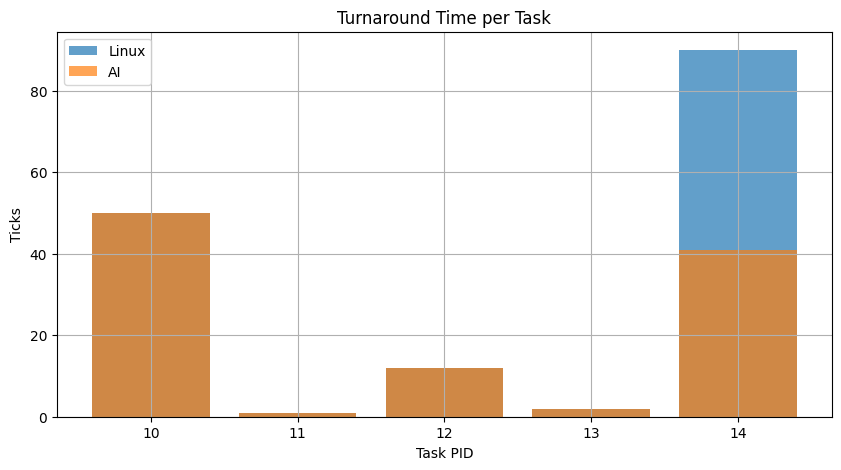

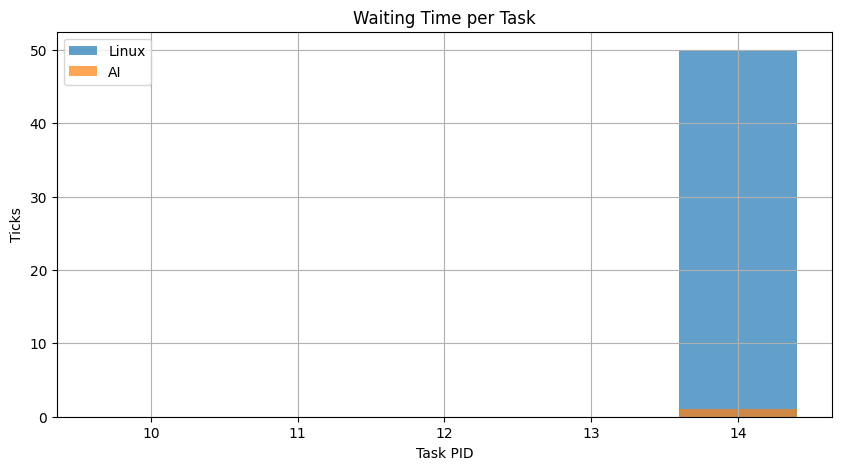

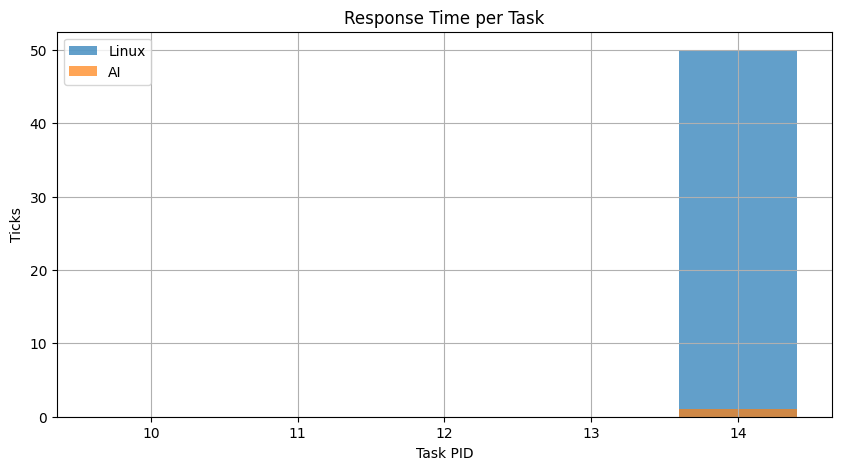

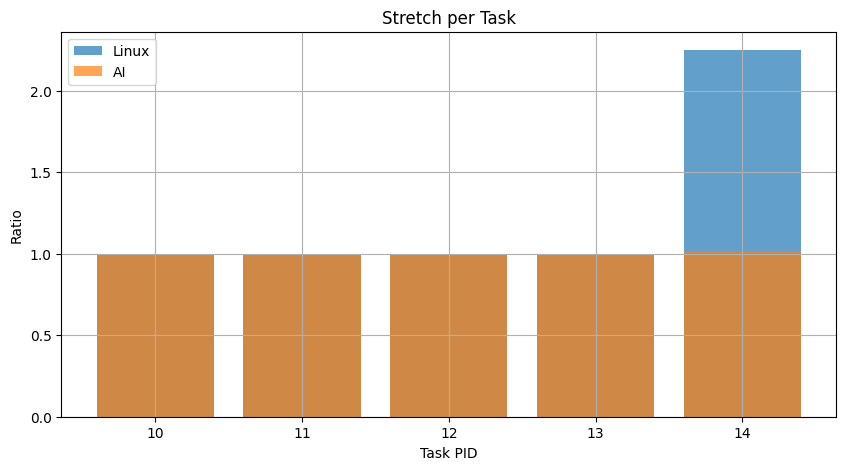

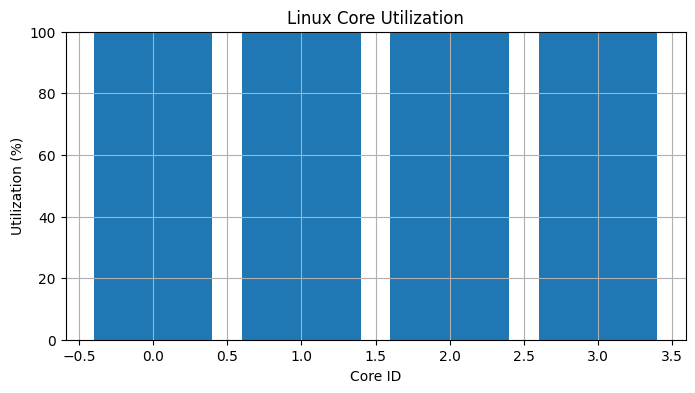

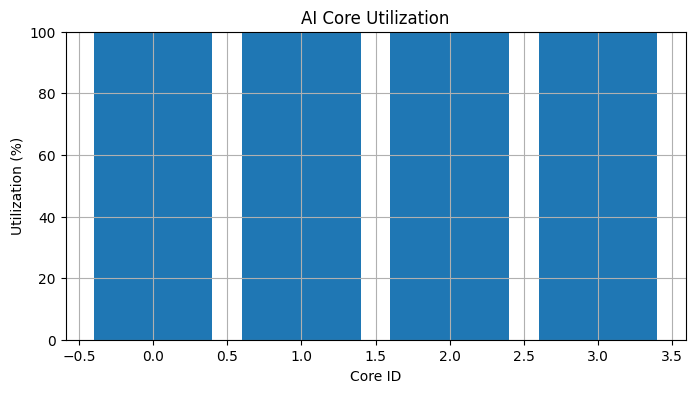

In [33]:
linux_logs = linux_sched.global_logs
ai_logs = scheduler_system.logs

linux_metrics, ai_metrics, summary, core_utils_linux, core_utils_ai = compare_schedulers(linux_logs, ai_logs, name1="Linux", name2="AI")

print("\n📊 Linux Task Metrics")
display(linux_metrics)

print("\n📊 AI Task Metrics")
display(ai_metrics)

print("\n📋 Scheduler Summary Comparison")
display(summary)

plot_scheduler_metrics(linux_metrics, ai_metrics, core_utils_linux, core_utils_ai)
